# Simulate genotype likelihoods (GL) from tree sequence data

In this jupyternotebook I'll create a series of python functions in order to simulate GL from tree structure data or the genotype matrix derived from it by using `tskit` package. For that, I'm based on Graham Gower's gist and `angsd`'s `msToGlf` program. 

Graham's gist:

https://gist.github.com/grahamgower/10779172a4a8368f993e154bf69dbe33

# 0. Importing packages for python and R

In [1]:
import time
import numpy as np
import pandas as pd 
import msprime
import tskit

from rpy2.robjects import r, pandas2ri
%load_ext rpy2.ipython
pandas2ri.activate()

* Project '/maps/projects/racimolab/people/qxz396/simGL' loaded. [renv 0.14.0]


In [2]:
%%R

.libPaths(c("/maps/projects/racimolab/people/qxz396/simGL/renv/library/R-4.1/x86_64-redhat-linux-gnu", "/tmp/Rtmp9Hi1cZ/renv-system-library"))

library(ggplot2)
library(tidyverse)

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1
✔ purrr   0.3.4     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



# 1. Simulate a haplotype matrix

From Graham's code, I use a function of his to simulate a tree

In [3]:
def sim(seeds=(1, 2), n = 5):
    ts = msprime.sim_ancestry(
        population_size=10_000,
        samples=n,
        sequence_length=100_000,
        recombination_rate=1.25e-8,
        random_seed=seeds[0],
        record_provenance=False,
    )
    ts = msprime.sim_mutations(ts, rate=1.25e-8, random_seed=seeds[1])
    return ts

ts = sim(seeds=(1, 2))
ts

Comments:

1. Why is it necessary to give different seeds?

From that, I extract the positions (reusing Graham's code):

In [4]:
pos = np.array(ts.tables.sites.position)
print(pos.shape)
pos

(115,)


array([  233.,   295.,  1688.,  2205.,  2515.,  2795.,  3357.,  4219.,
        4272.,  4337.,  4691.,  4824.,  5616.,  6598.,  6633.,  6886.,
        7378.,  7504.,  9248.,  9611., 10458., 11168., 11563., 12840.,
       13258., 13476., 14359., 14469., 15237., 15606., 15713., 16003.,
       16835., 17014., 17717., 18287., 18893., 19484., 25020., 25396.,
       26548., 27485., 27544., 27797., 30140., 30240., 32132., 32434.,
       32511., 32597., 32703., 32836., 32904., 32990., 34452., 35289.,
       36367., 36682., 37246., 39165., 39567., 41466., 42729., 43633.,
       43919., 45359., 45754., 46347., 49205., 49306., 49511., 49675.,
       50698., 50728., 54036., 54442., 55979., 56654., 56876., 56993.,
       57373., 60741., 60827., 61060., 61178., 64234., 67527., 67790.,
       70380., 73119., 73319., 74320., 74773., 74871., 74921., 78772.,
       79457., 79968., 81191., 82526., 82548., 83269., 83744., 84376.,
       84650., 86147., 86182., 89241., 90613., 92725., 92941., 93545.,
      

and extracting the haplotype allele counts (0 = anc allele, 1 = der allele)

In [5]:
M = ts.genotype_matrix()
print(M.shape)
M

(115, 10)


array([[1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

> ### Comments:
1. I change dimensions from Graham's original code and make rows (first dimension) to correspond to SNPs and columns (second dimension) to correspond to haplotypes.

# 2. Simulate GL

To simulate the GL from haplotypic allele counts, I'm going to use a similar approach than ANGSD `msToGlf` using the GL model from GATK (as shown in the picture abovell:

1. sample the mean **coverage per haplotype** (assuming that coverage is **distributed normally** among individuals with a std = 0.05\*mean  from the mean) 
2. sample **coverage per site per haplotype** (assuming **poison distribution** with lambda equal to the haplotype coverage)
3. sample as many **alleles reads** as depth per site per haplotype from a **multinomial distribution** with probabilities (1-e, e/3, e/3, e/3), assuming that the first position in the array corresponds to calling the correctly the allele and the rest correspond to calling an error.
4. assuming that index 0 = A = anc, index 1 = C = der, index 2 = G, index 3 = T, I'll **organize the allele read counts** in each array drawn from the multinomial distribution to correspond to the simulated allele counts per haplotype. Then, I'll **join every two haplotypes** to get the allele read counts per diploid individual.
5. **Compute GLs**


![Gl](GL.png)

source: 
1. http://www.popgen.dk/angsd/index.php/Genotype_Likelihoods
2. https://bmcbioinformatics.biomedcentral.com/track/pdf/10.1186/1471-2105-14-289.pdf

## 2.1. Coverage per haplotype

In [6]:
rng = np.random.default_rng(1234) #Why setting the seed like this?
mean_depth = 30
#mean_depths = rng.exponential(mean_depth, size=A.shape[1]) #Why exponential?
mean_depths = rng.normal(loc = mean_depth/2, scale = 0.05*mean_depth, size=M.shape[1])
print(mean_depths.shape)
mean_depths

(10,)


array([12.59424479, 15.09614987, 16.11133694, 15.22892879, 16.29561584,
       19.36964883, 12.78176496, 16.41820946, 12.50079681, 15.51561687])

> ### Comments:
1. Why is the coverage per individual sampled from an exponential distribution? I usually observe this to be normally distributed. I would be also nice to be able to define beforehand the coverage per sample.
2. Why setting the coverage like that?

## 2.2. Coverage per SNP per haplotype

In [7]:
DP = rng.poisson(mean_depths, size=M.shape)
print(DP.shape)
DP[:10, :]

(115, 10)


array([[12, 17, 19, 11, 18, 18, 17, 10, 16, 20],
       [11,  9, 16, 15, 25, 19, 10, 18, 12, 12],
       [11, 13, 21,  9, 18, 30, 16, 14, 18,  8],
       [12, 13, 25, 13, 14, 19, 15, 18,  9, 14],
       [15, 17, 17,  6, 19, 22, 18, 10,  8, 15],
       [ 6, 15, 13, 21, 24, 10,  8, 23, 10, 15],
       [13, 26, 19, 15, 21, 12, 13, 16, 14, 12],
       [ 9, 23, 19,  7, 17, 22, 16, 13, 18, 18],
       [11, 20, 14,  6, 14, 16, 14, 21,  8, 15],
       [11, 15, 17, 15,  7, 18, 13, 18, 16, 12]])

> ### Comments:

1. I don't think reshaping is necessary

## 2.3. Sampling allele reads for each haplotype and site with and without errors

Base pairs are coded in the following way:

1. 0 = correctly called allele
2. 1 = 2 = 3 = error called

If we check the coverage per site per haplotype...

In [8]:
print(DP.shape)
DP

(115, 10)


array([[12, 17, 19, ..., 10, 16, 20],
       [11,  9, 16, ..., 18, 12, 12],
       [11, 13, 21, ..., 14, 18,  8],
       ...,
       [10, 19, 17, ..., 12, 14,  9],
       [15, 13, 18, ..., 19, 10, 20],
       [11, 11, 14, ..., 20, 11, 21]])

This means that for the first haplotype and first position there should be 12 alleles sampled in total. I'll do that by sampling from a multinomial distribution with probabilities (1-e, e/3, e/3, e/3).

In [9]:
e = 0.05
reads_per_haplotype = np.array([rng.multinomial(dp, [1-e, e/3, e/3, e/3]).tolist() for dp in DP.reshape(-1)]).reshape(DP.shape[0], DP.shape[1], 4)
print(reads_per_haplotype.shape)
reads_per_haplotype

(115, 10, 4)


array([[[12,  0,  0,  0],
        [17,  0,  0,  0],
        [18,  1,  0,  0],
        ...,
        [10,  0,  0,  0],
        [15,  1,  0,  0],
        [19,  1,  0,  0]],

       [[11,  0,  0,  0],
        [ 9,  0,  0,  0],
        [15,  0,  1,  0],
        ...,
        [16,  0,  1,  1],
        [11,  1,  0,  0],
        [12,  0,  0,  0]],

       [[ 9,  1,  1,  0],
        [11,  1,  1,  0],
        [20,  1,  0,  0],
        ...,
        [13,  1,  0,  0],
        [18,  0,  0,  0],
        [ 8,  0,  0,  0]],

       ...,

       [[ 9,  0,  0,  1],
        [18,  1,  0,  0],
        [17,  0,  0,  0],
        ...,
        [12,  0,  0,  0],
        [14,  0,  0,  0],
        [ 9,  0,  0,  0]],

       [[14,  0,  0,  1],
        [11,  0,  2,  0],
        [17,  0,  1,  0],
        ...,
        [19,  0,  0,  0],
        [ 9,  1,  0,  0],
        [20,  0,  0,  0]],

       [[10,  1,  0,  0],
        [10,  0,  0,  1],
        [14,  0,  0,  0],
        ...,
        [18,  0,  0,  2],
        [10,  0

We can see that the first line summed up is the same as the first position in the depth array (DP) shown before. Rows that have counts in places other than the first position, correspond to errors. 

## 2.4. Organizing allele reads for each haplotype corresponding to the allele counts simulated

In this section I'll change the counts of the first and second positions of every array depending on the allele counts `M` depending on a given individual and site having the derived or ancestral allele such that in a given array:

1. index 0 = A = ancestral allele
2. index 1 = C = derived allele
3. index 2 = G
4. index 3 = T

So, if we check the M matrix:

In [10]:
M

array([[1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 1, 0, 0],
       ...,
       [0, 1, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

We can see that the first haplotype has a derived allele in the first SNP. Thus, we must swap the allele read counts between the first and second position of the first array in `reads_per_haplotype`.

In [11]:
reads_per_haplotype_copy = np.copy(reads_per_haplotype)
reads_per_haplotype[M == 1, 1] = reads_per_haplotype_copy[M == 1, 0]
reads_per_haplotype[M == 1, 0] = reads_per_haplotype_copy[M == 1, 1]
print(reads_per_haplotype.shape)
reads_per_haplotype

(115, 10, 4)


array([[[ 0, 12,  0,  0],
        [ 0, 17,  0,  0],
        [ 1, 18,  0,  0],
        ...,
        [ 0, 10,  0,  0],
        [ 1, 15,  0,  0],
        [ 1, 19,  0,  0]],

       [[11,  0,  0,  0],
        [ 9,  0,  0,  0],
        [15,  0,  1,  0],
        ...,
        [16,  0,  1,  1],
        [11,  1,  0,  0],
        [12,  0,  0,  0]],

       [[ 9,  1,  1,  0],
        [ 1, 11,  1,  0],
        [20,  1,  0,  0],
        ...,
        [ 1, 13,  0,  0],
        [18,  0,  0,  0],
        [ 8,  0,  0,  0]],

       ...,

       [[ 9,  0,  0,  1],
        [ 1, 18,  0,  0],
        [17,  0,  0,  0],
        ...,
        [ 0, 12,  0,  0],
        [14,  0,  0,  0],
        [ 9,  0,  0,  0]],

       [[14,  0,  0,  1],
        [11,  0,  2,  0],
        [17,  0,  1,  0],
        ...,
        [19,  0,  0,  0],
        [ 9,  1,  0,  0],
        [ 0, 20,  0,  0]],

       [[10,  1,  0,  0],
        [10,  0,  0,  1],
        [14,  0,  0,  0],
        ...,
        [18,  0,  0,  2],
        [10,  0

We can see that with this operation, the allele counts for the first and second position of SNPs for which haplotypes have the derived allele called have been swapped. 

> ### Comments:

1. There might be a better way to do this operation with numpy...

Finally, I can merge every two haplotypes to simulate diploid individuals. So, instead of having 10 haplotypes, I'll have only 5 individuals with the information corresponding to the allele read counts for every site. 

In [12]:
reads_per_genotype = reads_per_haplotype.reshape(reads_per_haplotype.shape[0], reads_per_haplotype.shape[1]//2, 2, reads_per_haplotype.shape[2]).sum(axis = 2)
print(reads_per_genotype.shape)
reads_per_genotype

(115, 5, 4)


array([[[ 0, 29,  0,  0],
        [ 1, 29,  0,  0],
        [18, 18,  0,  0],
        [ 0, 27,  0,  0],
        [ 2, 34,  0,  0]],

       [[20,  0,  0,  0],
        [30,  0,  1,  0],
        [23, 20,  1,  0],
        [25,  0,  2,  1],
        [23,  1,  0,  0]],

       [[10, 12,  2,  0],
        [20, 10,  0,  0],
        [17, 27,  1,  3],
        [16, 13,  1,  0],
        [26,  0,  0,  0]],

       ...,

       [[10, 18,  0,  1],
        [25,  2,  0,  0],
        [ 0, 37,  1,  1],
        [14, 12,  0,  0],
        [23,  0,  0,  0]],

       [[25,  0,  2,  1],
        [33,  0,  1,  0],
        [35,  1,  0,  0],
        [19, 15,  1,  0],
        [ 9, 21,  0,  0]],

       [[20,  1,  0,  1],
        [14, 10,  0,  0],
        [38,  0,  1,  0],
        [29,  0,  1,  2],
        [31,  0,  0,  1]]])

## 2.5. Compute GLs

In [13]:
#AA, AC, AG, AT, CC, CG, CT, GG, GT, TT
#00, 01, 02, 03, 11, 12, 13, 22, 23, 33
GL = []
for i in range(4):
    for j in range(i, 4):
        if i == j:
            GL.append(-np.log(np.power(((1-e)/2 + (1-e)/2), reads_per_genotype[:, :, i]) * 
                             np.power(((e/3)/2 + (e/3)/2), reads_per_genotype.sum(axis = 2)-reads_per_genotype[:, :, i])))
        else:
            
            GL.append(-np.log(np.power(((1-e)/2 + (e/3)/2), reads_per_genotype[:, :, i]+reads_per_genotype[:, :, j]) * 
                             np.power(((e/3)/2 + (e/3)/2), reads_per_genotype.sum(axis = 2)-reads_per_genotype[:, :, i]-reads_per_genotype[:, :, j])))

GL = np.array(GL)
GL = GL - GL.min(axis = 0)
print(GL.shape)
GL

(10, 115, 5)


array([[[117.24848677, 113.2054355 ,  48.44772706, 109.16238423,
         129.37764057],
        [  0.        ,   0.        ,  51.80354153,   0.        ,
           0.        ],
        [ 33.64999558,  20.15784954,  79.42914497,  32.96275878,
           0.        ],
        ...,
        [ 53.85377056,   0.        , 149.59289691,  30.94697383,
           0.        ],
        [  0.        ,   0.        ,   0.        ,  37.67008413,
          64.63141349],
        [  0.        ,  24.21238217,   0.        ,   0.        ,
           0.        ]],

       [[ 19.5969077 ,  16.22961187,   0.        ,  18.24539682,
          16.24109323],
        [ 13.51510876,  20.27266314,   0.        ,  16.89388595,
          12.17507924],
        [  0.        ,   0.        ,   0.        ,   0.        ,
          17.56964138],
        ...,
        [  0.        ,  10.15929429,  25.0029512 ,   0.        ,
          15.54237507],
        [ 16.89388595,  22.29992945,  20.28414449,   0.        ,
           0.    

## 3. All together and running time tests

Here I just put all the steps together in a single function and run it for different simulated datasets with varying number of individuals to test how fast the function is. 

In [14]:
def samples_order(ts):
    so = []
    for ind in ts.individuals():
        [so.append(nod) for nod in ind.nodes]
    return np.array(so)

def extract_genotype_matrix(data):
    if type(data) == np.ndarray and len(data.shape) == 2:
        return data
    elif type(data) == tskit.trees.TreeSequence:
        return data.genotype_matrix()[:, samples_order(data)]
    else:
        sys.exit("Incorrect data format")

def depth_per_haplotype(rng, mean_depth, std_depth, n_ind):
    if type(mean_depth) == int or type(mean_depth) == float:
        if type(std_depth) == int or type(std_depth) == float:
            DPh = []
            while len(DPh) < n_ind:
                dp = rng.normal(loc = mean_depth/2, scale = std_depth, size=1)[0]
                if dp > 0:
                    DPh.append(dp)
            return DPh
    elif type(mean_depth) == np.ndarray and len(mean_depth.shape) == 1 and mean_depth.shape[0] == n_ind and (mean_depth > 0).sum() == n_ind:
        return mean_depth
    else:
        sys.exit("Incorrect mean_depth format")
        
        
def sim_allelereadcounts(data, mean_depth = 30., std_depth = 5., e = 0.05, seed = 1234):
    '''
    Def:
        Function to simulate read counts for alleles given a tree sequence data from diploid simulated individuals (2samples = ind) 
        or genotype matrix and extra information for the haplotype samples.
    Input:
        - data       : Two inputs are possible:
                            + Tree sequence data from tskit package from which the genotype matrix is going to be extracted
                            + Genotype matrix in numpy format with shape (SNPs, samples). It is assumed that the array is sorted
                              according to a individual order such that consecutive columns (e.g., data[:, 0] and data[:, 1]) 
                              correspond to the same individual.
        - mean_depth : Two inputs are possible:
                            + float > 0 with the mean depth per sample. The mean depth for every sample haplotype 
                              is going to be sampled from a normal distribution with mean = mean_depth and std = std_depth.
                              Consider that since this script assumes that individuals are diploid, if the user intends to 
                              simulate a coverage of 30X per individual, the argument should be set to 15.
                            + numpy array with shape (samples, ) with the mean depth per haplotype sample. All values must 
                              be > 0. The order of the values is going to be associated to the list of individual's samples
                              provided by ts.individuals() (in case a tree sequence data is provided) or the order of the
                              samples in the genotype matrix (if a genotype matrix is provided in the input data).
                              If the intended coverage per site for a given individual is 30, since the coverage is 
                              given per haplotype, it should be indicated consecutively and half the individual coverage (15 
                              and 15 or 14 and 16).
        - std_depth  : float that corresponds to the standard deviation of the normal distribution from which coverages are
                       going to be sampled. This value will only be used if a float value is inputet for mean_depth. 
        - e          : float between 0 and 1 representing the error rate per base per read per site. This probability is
                       assumed to be constant.
        - seed       : integer from which the numpy rng will be drawn. 
    Output:
        - Rg         : numpy array with dimentions (SNP, individual, alleles) so that each value corresponds to the number of
                       reads with a particular allele for a SNP position and a diploid individual. The index of the 3rd dimention
                       corresponds to 1 : A and ancestral allele, 2 : C and derived allele, 3 : G, 4: T. 
    '''
    rng = np.random.default_rng(seed)
    M   = extract_genotype_matrix(data)
    #1. Depths per haplotype
    DPh = depth_per_haplotype(rng, mean_depth, std_depth, M.shape[1])
    #2. Sample depths per SNP per haplotype
    DP  = rng.poisson(DPh, size=M.shape)
    #3. Sample correct and error reads per SNP per haplotype (Rh)
    Rh  = np.array([rng.multinomial(dp, [1-e, e/3, e/3, e/3]).tolist() for dp in DP.reshape(-1)])
    Rh  = Rh.reshape(DP.shape[0], DP.shape[1], 4)
    #4. Reorganize anc and der alleles and join haplotypes to form individuals
    Rh_copy = np.copy(Rh)
    Rh[M == 1, 1] = Rh_copy[M == 1, 0]
    Rh[M == 1, 0] = Rh_copy[M == 1, 1]
    return Rh.reshape(Rh.shape[0], Rh.shape[1]//2, 2, Rh.shape[2]).sum(axis = 2)

    
def allelereadcounts_to_GL(Rg, e):
    GL = []
    for i in range(4):
        for j in range(i, 4):
            if i == j:
                GL.append(-np.log(np.power(((1-e)/2 + (1-e)/2), Rg[:, :, i]) * 
                                  np.power(((e/3)/2 + (e/3)/2), Rg.sum(axis = 2)-Rg[:, :, i])))
            else:
            
                GL.append(-np.log(np.power(((1-e)/2 + (e/3)/2), Rg[:, :, i]+Rg[:, :, j]) * 
                                  np.power(((e/3)/2 + (e/3)/2), Rg.sum(axis = 2)-Rg[:, :, i]-Rg[:, :, j])))

    GL = np.array(GL)
    return GL - GL.min(axis = 0)



In [15]:
ts = sim(seeds=(1, 2), n = 5)
ts
Rg = sim_allelereadcounts(ts, mean_depth = 15., std_depth = 3., e = 0.05, seed = 1234)
print(Rg.shape)
print(Rg)

(115, 5, 4)
[[[ 1 11  0  1]
  [ 0 12  1  2]
  [15 12  1  1]
  [ 0 12  0  0]
  [ 0 13  1  0]]

 [[ 7  0  0  0]
  [15  0  0  0]
  [ 9 15  0  0]
  [13  0  0  0]
  [10  1  0  1]]

 [[ 4  2  1  1]
  [12  6  0  0]
  [13 12  0  0]
  [ 6  3  0  0]
  [ 9  0  0  0]]

 ...

 [[ 5  8  0  0]
  [14  0  3  0]
  [ 0 19  0  0]
  [ 4 12  0  0]
  [11  0  0  0]]

 [[ 5  0  1  0]
  [18  0  0  1]
  [19  1  1  1]
  [10  1  0  0]
  [ 2  2  2  0]]

 [[12  0  0  0]
  [11  5  0  0]
  [20  1  0  0]
  [14  0  1  0]
  [ 8  0  0  0]]]


In [16]:
GL = allelereadcounts_to_GL(Rg, e = 0.05)
print(GL.shape)
print(GL)

(10, 115, 5)
[[[4.04305127e+01 4.85166152e+01 3.02712184e+01 4.85166152e+01
   5.25596665e+01]
  [0.00000000e+00 0.00000000e+00 4.44276385e+01 0.00000000e+00
   0.00000000e+00]
  [4.03156991e+00 1.20947097e+01 3.16227293e+01 6.04735486e+00
   0.00000000e+00]
  ...
  [2.35595895e+01 6.41311360e-01 7.68179741e+01 3.77045282e+01
   0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   5.38308078e+00]
  [0.00000000e+00 9.40316933e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00]]

 [[4.06601399e+00 8.10906525e+00 0.00000000e+00 8.10906525e+00
   8.78482069e+00]
  [4.73028806e+00 1.01363316e+01 0.00000000e+00 8.78482069e+00
   3.39025855e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   6.08179894e+00]
  ...
  [0.00000000e+00 1.01018875e+01 1.28393533e+01 0.00000000e+00
   7.43330982e+00]
  [3.37877719e+00 1.21635979e+01 9.47205749e+00 3.39025855e+00
   0.00000000e+00]
  [8.10906525e+00 0.00000000e+00 1.01478129e+01 9.46057613e+00
   5.406

In [17]:
ns = [5, 10, 50, 100, 500, 1000, 5000]
xs = []
ws = []
for n in ns:
    print(n)
    ts = sim(seeds=(1, 2), n = n)
    xs.append(ts.num_mutations)
    start_time = time.time()
    allelereadcounts_to_GL(sim_allelereadcounts(ts, mean_depth = 30., std_depth = 5., e = 0.05, seed = 1234), e = 0.05)
    ws.append(time.time()-start_time)

5
10
50
100
500
1000
5000


In [18]:
df = pd.DataFrame({"n_ind" : ns, "n_snp" : xs, "time" :ws})
df

,n_ind,n_snp,time
0,5,115,0.022767
1,10,174,0.064761
2,50,192,0.580164
3,100,303,1.166897
4,500,397,9.780688
5,1000,448,23.408191
6,5000,479,145.201849


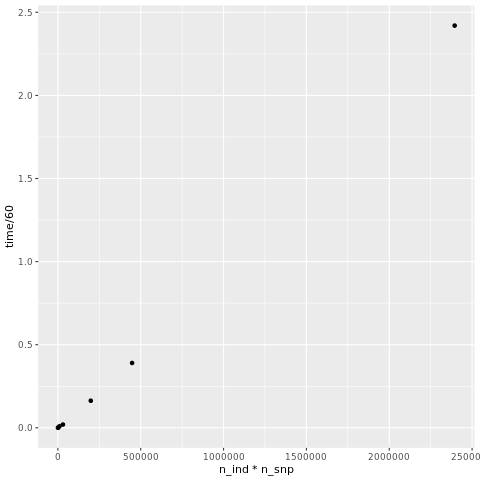

In [37]:
%%R -i df

df %>% 
    ggplot(aes(x = n_ind*n_snp, y = time/60)) +
    geom_point() 

So, we can se that to simulate GL for 10,000 individuals it takes less than 3 min. 

## 4. Further improvements

1. Introduce potential errors to invariable sites
2. Make possible a different reference sequence such that we do not need to assume that A = anc and C = der.
3. Check the order of individuals since nodes can be messed up. Check if the index of nodes it always goes from 0 to # nodes and are sorted in genotype matrix accordingly.
4. allow any ploidy

# 5. Testing GL calculation

To test that the computation of genotype likelihoods is correct, I'll compare to the results obtained with other programs (`angsd` and `bcftools`). 

For that, I'll first fake a test dataset in which there is only a single read "A" for a single position. The error rate is assumed to be $e = 0.05012$ since it corresponds to the ACII value "." in phred scale based 33 as it is explained in this [link](https://www.drive5.com/usearch/manual/quality_score.html). This is because the input of those programs is with the ACII coded error rates.

The genotype read alleles counts is the following:

In [20]:
test = np.array([[[1, 0, 0, 0]]])
test

array([[[1, 0, 0, 0]]])

### 5.1. Testing GL calculation by `allelereadcounts_to_GL()` function

In [21]:
allelereadcounts_to_GL(test, e = 0.05012)[:, 0, 0]

array([0.        , 0.67571188, 0.67571188, 0.67571188, 4.04052782,
       4.04052782, 4.04052782, 4.04052782, 4.04052782, 4.04052782])

### 5.2. GL from `angsd`

First, I'll creat a function that takes the "allelereadcounts" format and formats it to "pileup" in order to input the file to `angsd`. 

In [22]:
def allelereadcounts_to_pileup(allelereadcounts):
    with open("reads.pileup", "w") as out:
        first_line = True
        for i in range(allelereadcounts.shape[0]):
            line = "1\t"+str(i+1)+"\tN"
            for j in range(allelereadcounts.shape[1]):
                nreads = allelereadcounts[i, j, :].sum()
                line = line+"\t"+str(nreads)+"\t"
                if nreads:
                    for c, b in zip(allelereadcounts[i, j, :], ["A", "C", "G", "T"]):
                        line = line+c*b
                    line = line+"\t"+"."*nreads
                else:
                    line = line+"\t*\t*"
            out.write(line+"\n")
    
allelereadcounts_to_pileup(test)

In [23]:
%%bash

wc -l reads.pileup
head reads.pileup
gzip -c reads.pileup > reads.pileup.gz

1 reads.pileup
1	1	N	1	A	.


As we can see, there is a single read in position 1 for a single individual which corresponds to allele "A" with quality "." that corresponds to $e = 0.05012$. We are ready to run `angsd`.

In [24]:
%%bash

time angsd -GL 2                                                                            \
           -pileup reads.pileup.gz                                                          \
           -fai    ../spaceNNtime/jupyternotebooks/angsd_msToGlf_pileup_output/fasta.fa.fai \
           -doGlf  4                                                                        \
           -nind   1

	-> angsd version: 0.935-53-gf475f10 (htslib: 1.14) build(Dec 13 2021 09:22:17)
	-> angsd -GL 2 -pileup reads.pileup.gz -fai ../spaceNNtime/jupyternotebooks/angsd_msToGlf_pileup_output/fasta.fa.fai -doGlf 4 -nind 1 
	-> No '-out' argument given, output files will be called 'angsdput'
	-> Inputtype is pileup
	-> You are using -pileup, this means:
	-> 1) Internal positions both from front and back is coded to 255
	-> 2) All mapping qualities (mapQ) are set to 30
	-> 3) Program will not represent insertions, use raw BAM/CRAM for that
	-> Done reading data waiting for calculations to finish
	-> Done waiting for threads
	-> Output filenames:
		->"angsdput.arg"
		->"angsdput.glf.gz"
	-> Fri Dec 17 19:42:27 2021
	-> Arguments and parameters for all analysis are located in .arg file
	-> Total number of sites analyzed: 1
	-> Number of sites retained after filtering: 1 
	[ALL done] cpu-time used =  0.00 sec
	[ALL done] walltime used =  0.00 sec

real	0m0.015s
user	0m0.007s
sys	0m0.002s


In [25]:
%%bash

zcat angsdput.glf.gz

1	1	0.000000	-0.675712	-0.675712	-0.675712	-4.040555	-4.040555	-4.040555	-4.040555	-4.040555	-4.040555


### 5.3. GL from `bcftools`

In this case, I need to simulate a "sam" mapped file which will be transformed to "bam" to be inputed to `bcftools mpileup`.

In [26]:
def allelereadcounts_to_SAM(allelereadcounts):
    counts = 0
    for ind in range(allelereadcounts.shape[1]):
        with open("ind"+str(ind)+".sam", "w") as out:
            out.write("@SQ\tSN:1\tLN:100000\n")
            for pos in range(allelereadcounts.shape[0]):
                for bp, rep in zip(["A", "C", "G", "T"], allelereadcounts[pos, ind]):
                    for z in range(rep):
                        QNAME = str(ind)+"_"+str(pos)+"_"+str(counts)
                        FLAG  = "0"
                        RNAME = "1"
                        POS   = str(pos+1)
                        MAPQ  = "255"
                        CIGAR = "1M"
                        RNEXT = "*"
                        PNEXT = "0"
                        TLEN  = "0"
                        SEQ   = bp
                        QUAL  = "M"
                        counts += 1
                        out.write("\t".join([QNAME, FLAG, RNAME, POS, MAPQ, CIGAR, RNEXT, PNEXT, TLEN, SEQ, QUAL])+"\n")
                        
allelereadcounts_to_SAM(test)

In [27]:
%%bash

wc -l ind0.sam
head ind0.sam

2 ind0.sam
@SQ	SN:1	LN:100000
0_0_0	0	1	1	255	1M	*	0	0	A	M


In [28]:
%%bash

samtools view -bS ind0.sam > ind0.bam

In [29]:
%%bash

bcftools mpileup ind0.sam --no-reference 

##fileformat=VCFv4.2
##FILTER=<ID=PASS,Description="All filters passed">
##bcftoolsVersion=1.14+htslib-1.14
##bcftoolsCommand=mpileup --no-reference ind0.sam
##contig=<ID=1,length=100000>
##ALT=<ID=*,Description="Represents allele(s) other than observed.">
##INFO=<ID=INDEL,Number=0,Type=Flag,Description="Indicates that the variant is an INDEL.">
##INFO=<ID=IDV,Number=1,Type=Integer,Description="Maximum number of raw reads supporting an indel">
##INFO=<ID=IMF,Number=1,Type=Float,Description="Maximum fraction of raw reads supporting an indel">
##INFO=<ID=DP,Number=1,Type=Integer,Description="Raw read depth">
##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)",Version="3">
##INFO=<ID=RPBZ,Number=1,Type=Float,Description="Mann-Whitney U-z test of Read Position Bias (closer to 0 is better)">
##INFO=<ID=MQBZ,Number=1,Type=Float,Description="Mann-Whitney U-z test of Mapping Quality Bias (closer to 0 is b

[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 250


### 5.4. All results together and more testing

We can see that the GL derived from our function and `angsd` is very similar (let alown that they have oposite signs). I can't make much sense about the `bcftools` result which in the future I'll have a look. Then, I can try with a more complex example. In this case the individual is supposed to be still homozygote "CC".

In [30]:
test = Rg[0, 0, :].reshape(1, 1, 4)
test

array([[[ 1, 11,  0,  1]]])

In [31]:
allelereadcounts_to_GL(test, e = 0.05012)[:, 0, 0]*-1

array([-40.40527819,  -4.06801469, -41.08099007, -37.71617413,
        -0.        ,  -7.43283064,  -4.06801469, -44.44580601,
       -41.08099007, -40.40527819])

In [32]:
allelereadcounts_to_pileup(test)

In [33]:
%%bash

gzip -c reads.pileup > reads.pileup.gz

time angsd -GL 2                                                                            \
           -pileup reads.pileup.gz                                                          \
           -fai    ../spaceNNtime/jupyternotebooks/angsd_msToGlf_pileup_output/fasta.fa.fai \
           -doGlf  4                                                                        \
           -nind   1

zcat angsdput.glf.gz

1	1	-40.405546	-4.067993	-41.081259	-37.716416	0.000000	-7.432836	-4.067993	-44.446101	-41.081259	-40.405546


	-> angsd version: 0.935-53-gf475f10 (htslib: 1.14) build(Dec 13 2021 09:22:17)
	-> angsd -GL 2 -pileup reads.pileup.gz -fai ../spaceNNtime/jupyternotebooks/angsd_msToGlf_pileup_output/fasta.fa.fai -doGlf 4 -nind 1 
	-> No '-out' argument given, output files will be called 'angsdput'
	-> Inputtype is pileup
	-> You are using -pileup, this means:
	-> 1) Internal positions both from front and back is coded to 255
	-> 2) All mapping qualities (mapQ) are set to 30
	-> 3) Program will not represent insertions, use raw BAM/CRAM for that
	-> Done reading data waiting for calculations to finish
	-> Done waiting for threads
	-> Output filenames:
		->"angsdput.arg"
		->"angsdput.glf.gz"
	-> Fri Dec 17 19:42:27 2021
	-> Arguments and parameters for all analysis are located in .arg file
	-> Total number of sites analyzed: 1
	-> Number of sites retained after filtering: 1 
	[ALL done] cpu-time used =  0.00 sec
	[ALL done] walltime used =  0.00 sec

real	0m0.016s
user	0m0.007s
sys	0m0.003s


Very close.

Finally, let's try a heterozygote example.

In [34]:
test = np.array([[[1, 1, 16, 15]]])
allelereadcounts_to_pileup(test)
allelereadcounts_to_GL(test, e = 0.05012)[:, 0, 0]*-1

array([-100.26876642,  -97.57966236,  -47.10742321,  -50.47223915,
       -100.26876642,  -47.10742321,  -50.47223915,  -39.66084913,
         -0.        ,  -43.70137695])

In [35]:
%%bash

gzip -c reads.pileup > reads.pileup.gz

time angsd -GL 2                                                                            \
           -pileup reads.pileup.gz                                                          \
           -fai    ../spaceNNtime/jupyternotebooks/angsd_msToGlf_pileup_output/fasta.fa.fai \
           -doGlf  4                                                                        \
           -nind   1

zcat angsdput.glf.gz

1	1	-100.269557	-97.580427	-47.107792	-50.472634	-100.269557	-47.107792	-50.472634	-39.661237	0.000000	-43.701792


	-> angsd version: 0.935-53-gf475f10 (htslib: 1.14) build(Dec 13 2021 09:22:17)
	-> angsd -GL 2 -pileup reads.pileup.gz -fai ../spaceNNtime/jupyternotebooks/angsd_msToGlf_pileup_output/fasta.fa.fai -doGlf 4 -nind 1 
	-> No '-out' argument given, output files will be called 'angsdput'
	-> Inputtype is pileup
	-> You are using -pileup, this means:
	-> 1) Internal positions both from front and back is coded to 255
	-> 2) All mapping qualities (mapQ) are set to 30
	-> 3) Program will not represent insertions, use raw BAM/CRAM for that
	-> Done reading data waiting for calculations to finish
	-> Done waiting for threads
	-> Output filenames:
		->"angsdput.arg"
		->"angsdput.glf.gz"
	-> Fri Dec 17 19:42:27 2021
	-> Arguments and parameters for all analysis are located in .arg file
	-> Total number of sites analyzed: 1
	-> Number of sites retained after filtering: 1 
	[ALL done] cpu-time used =  0.00 sec
	[ALL done] walltime used =  0.00 sec

real	0m0.016s
user	0m0.006s
sys	0m0.004s


The results are pretty close, so we can assume that it is correct since it seems the error is about the rounding. 

In [36]:
%%bash 

rm -f angsdput.glf.gz ind*.sam ind*.bam angsdput*